In [120]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=e4f971b374f2e9218ecc1eddc29e57ac685ebb2ace5e3778969f0b8a17658cca
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=ab7f4effd972132582ba18bff4d0aad0ad739c98c8111d0003461bbd91795c94
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [123]:
import numpy as np
import torch
import math
import umap.umap_ as umap
import os
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [13]:
DATA_DIR = '/content/drive/MyDrive/AML_project/datasets/FMNIST_DATASET'
BATCH_SIZE = 200
SEED = 42
LOAD_MODEL = False

In [21]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

if os.path.isdir(DATA_DIR):
    train_data = FashionMNIST(root=DATA_DIR, train=True, transform=transforms.ToTensor())
    test_data = FashionMNIST(root=DATA_DIR, train=False, transform=transforms.ToTensor())
else:
    os.mkdir(DATA_DIR)
    train_data = FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transforms.ToTensor())
    test_data = FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=1,
                          drop_last=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=1,
                         drop_last=False)

fmnist_classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [26]:
def display(images, length):
    f, axes = plt.subplots(1, length, sharex='col', sharey='row')
    plt.figure(figsize=(18, 6))
    for i, image in enumerate(images):
        image = image.data.cpu().view(28, 28)
        if len(images) > 1:
            _ = axes[i].imshow(image, cmap='gray')
        else:
            _ = axes.imshow(image, cmap='gray')
def reparametrize(mu, std, device):
    """
    Performs reparameterization trick z = mu + epsilon * std
    Where epsilon~N(0,1)
    """
    mu = mu.expand(1, *mu.size())
    std = std.expand(1, *std.size())
    eps = torch.normal(0, 1, size=std.size()).to(device)
    return mu + eps * std

class FMNIST_VANILA_VAE(nn.Module):
    """
    Just your regular variational auto encoder (not IB)
    """
    def __init__(self, k, device):
        super(FMNIST_VANILA_VAE, self).__init__()
        self.device = device
        self.description = 'Vanilla IB VAE as per the paper'
        self.k = k
        self.train_loss = []
        self.test_loss = []

        self.encoder = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2 * self.k))

        self.decoder = nn.Sequential(
                nn.Linear(self.k, 1024),
                nn.ReLU(True),
                nn.Linear(1024, 28*28),
                nn.Sigmoid())

        # Xavier initialization
        for _, module in self._modules.items():
            for layer in module:
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                            nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
                            layer.bias.data.zero_()

    def forward(self, x):
        # squiwsh from shape (100,1,28,28) to (100,784)
        x = x.view(x.size(0),-1)
        z_params = self.encoder(x)
        mu = z_params[:, :self.k]
        # softplus transformation (soft relu) and a -5 bias is added as in the paper
        std = F.softplus(z_params[:, self.k:] - 5, beta=1)
        if self.training:
            z = reparametrize(mu, std, self.device)
        else:
            z = mu.clone().unsqueeze(0)
        decoded = self.decoder(z)
        return (mu, std), decoded[0]

def vae_loss(x_hat, x, mu, std, beta):
    reconstruction_loss = F.mse_loss(x_hat.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    normalization_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum()
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return reconstruction_loss + beta * normalization_loss

In [27]:
def loop_data(model, dataloader, beta,
              is_train, model_save_path, epochs,
              device, optimizer=None, scheduler=None):
    """
    loops over the dataset, collects metrics and train 
    a model if is_train is True
    """
    if is_train:
        model.train()
    else:
        model.eval()
        epochs = 1

    for e in range(epochs):
        epoch_loss = 0        
        for batch_num, (images, labels) in enumerate(dataloader):
            x = images.to(device)
            y = labels.to(device)
            (mu, std), decoded = model(x)
            batch_loss = vae_loss(decoded.view(-1, 28*28), x.view(-1, 28*28),
                                  mu, std, beta)
            if is_train:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            epoch_loss += batch_loss.item()

            if is_train and (batch_num % 100) == 0:
                print('batch loss:{:.2f}'.format(batch_loss.item()))
        
        epoch_loss /= batch_num
        if is_train:
            model.train_loss.append(epoch_loss)
        else:
            model.test_loss.append(epoch_loss)
        
        if len(model.test_loss) > 1 and not is_train:
            if (epoch_loss < min(model.test_loss)):
                torch.save(model, model_save_path)
                print('Saved model to {}'.format(model_save_path))

        if not is_train:
            print('[TEST RESULTS]')
            print('epoch loss:{:.2f}'.format(epoch_loss))


In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/AML_project/saved_models/fmnist_vanilla_vae.h5'
K = 256
LR = 1e-4
EPOCHS = 100
BETA = 1e-3

model = FMNIST_VANILA_VAE(K, device).to(device)
optimizer = optim.Adam(model.parameters(), LR, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

for epoch in range(EPOCHS):
    loop_data(model, train_loader, BETA, is_train=True, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    loop_data(model, test_loader, BETA, is_train=False, 
              model_save_path=MODEL_SAVE_PATH, epochs=1, device=device,
              optimizer=optimizer, scheduler=scheduler)

    if (epoch % 2) == 0 and (epoch != 0):
        scheduler.step()

print("----- Training complete -----")

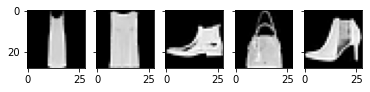

<Figure size 1296x432 with 0 Axes>

In [83]:
display(images[0:5], 5)

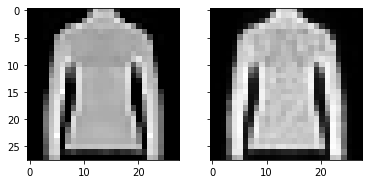

<Figure size 1296x432 with 0 Axes>

In [108]:
I = 23
x = images[I]
(_, _), x_hat = model(x.cuda())
x_hat = x_hat.view(-1, 28*28)
display([x, x_hat], 2)

In [192]:
latent_list = []
label_list = []
label_text_list = []
model.eval()
for idx, (image_batch, label_batch) in enumerate(train_loader):
    with torch.no_grad():
        (mu, _), _ = model(image_batch.to(device))
        latent_list += [mu1.unsqueeze(0).cpu() for mu1 in mu]
    label_list += [int(label) for label in label_batch]
    label_text_list += [fmnist_classes[int(label)] for label in label_batch]
    if idx > 100:
        break
latent_array = np.array([tensor.cpu().numpy()[0] for tensor in latent_list])

In [193]:
reducer = umap.UMAP()
scaler = StandardScaler().partial_fit(latent_array)
scaled_data = scaler.transform(latent_array)
embedding = reducer.fit_transform(scaled_data)

Text(0.5, 1.0, 'Casted latent instances')

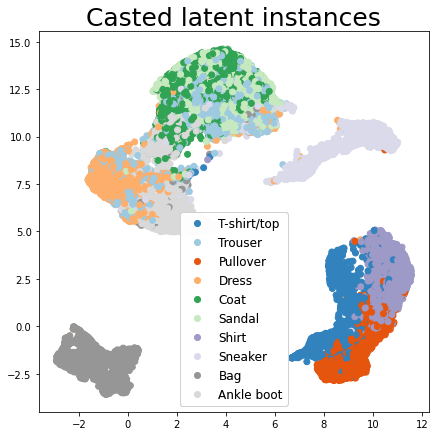

In [200]:
labels = pd.Series(label_text_list)
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
c = [[c for c in range(1,11)][x] for x in labels\
       .map({label: i for i, label in enumerate(labels.unique())})]

scatter = axes.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=c,
                    cmap='tab20c')

# TODO: fix legend real class correlation
legend1 = axes.legend(scatter.legend_elements()[0],\
                    [text for text in fmnist_classes],\
                    fontsize=18, prop={'size': 12})

axes.add_artist(legend1)
fig.canvas.draw()
axes.set_title('Casted latent instances', fontsize=25)
# plt.savefig('test.png')

### Generate some instaces

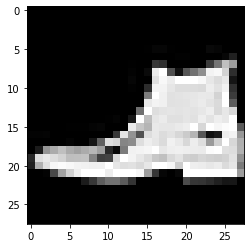

<Figure size 1296x432 with 0 Axes>

In [213]:
display(images[2], 1)

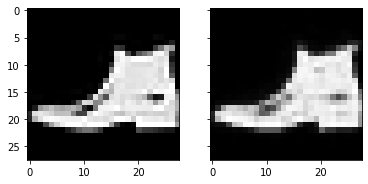

<Figure size 1296x432 with 0 Axes>

In [256]:
# i = np.random.randint(0,199)
i = 2
(mu, sigma), _ = model(images[i].to(device))
z1 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z1)
display([images[i], sample], 2)

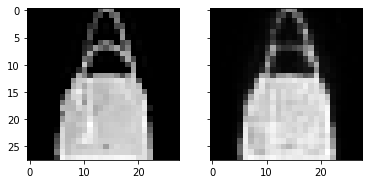

<Figure size 1296x432 with 0 Axes>

In [257]:
# i = np.random.randint(0,199)
i = 3
(mu, sigma), _ = model(images[i].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder(z2)
display([images[i], sample], 2)

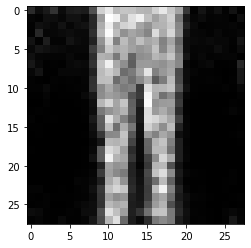

<Figure size 1296x432 with 0 Axes>

In [266]:
inv_transformed_points = reducer.inverse_transform([[-1,-2]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

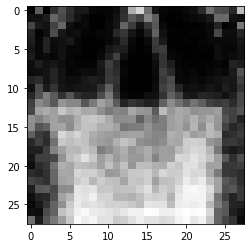

<Figure size 1296x432 with 0 Axes>

In [268]:
inv_transformed_points = reducer.inverse_transform([[7,8]])
sample = model.decoder(torch.tensor(inv_transformed_points).to(device))
display([sample], 1)

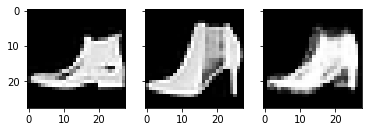

<Figure size 1296x432 with 0 Axes>

In [277]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2))
display([images[i1], images[i2], sample], 3)

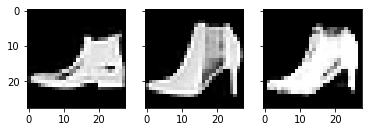

<Figure size 1296x432 with 0 Axes>

In [278]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+2*z2))
display([images[i1], images[i2], sample], 3)

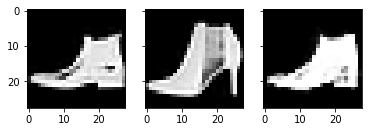

<Figure size 1296x432 with 0 Axes>

In [279]:
i1=2
i2=4
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2))
display([images[i1], images[i2], sample], 3)

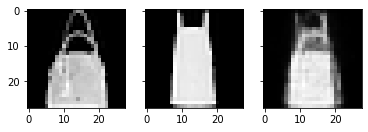

<Figure size 1296x432 with 0 Axes>

In [282]:
i1=3
i2=6
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((z1+z2)/2)
display([images[i1], images[i2], sample], 3)

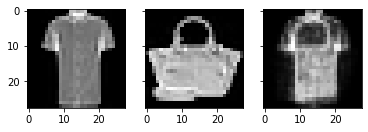

<Figure size 1296x432 with 0 Axes>

In [321]:
i1=10
i2=35
(mu, sigma), _ = model(images[i1].to(device))
z1 = torch.normal(mu, sigma).to(device)
(mu, sigma), _ = model(images[i2].to(device))
z2 = torch.normal(mu, sigma).to(device)
sample = model.decoder((2*z1+z2)/2)
display([images[i1], images[i2], sample], 3)